# Agrupar 

Agruparemos utilizando 2 enfoques:

- Por subtítulos
- Por videos 

Para analizar de una manera más detallada el corpus

In [16]:
#Para el corpus
import sys
sys.path.append('..')
from src.data import Data 
#Para calcular TF-IDF
from src.tfidf import TFIDF
#Para graficar palabras
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm 

## Vectores TF-IDF

### Gráficamos los vectores de TF-IDF de cada subtítulo 

In [18]:
#Cargamos el corpus limpio
videos = Data("../pkl/clean_videos.pkl")
videos.get_all_subtitles()
#Creamos el objeto tfidf
tfidf_objxO = TFIDF(videos)
# Cargamos los valores tfidf previamente calculados
tfidf_objxO.tfidf = "../pkl/tfidfxOracion.pkl" #Vectores por texto
# Obtenemos los vectores por subtítulo
tfidf_objxO.get_tfid_vectors(document=False)

100%|██████████| 9/9 [00:00<00:00, 14.84it/s]


Longitud de la oración más larga:  56


100%|██████████| 9/9 [00:06<00:00,  1.40it/s]


In [19]:
def get_vectors():
    '''
    Regresa un diccionario con los subtítulos y su vector tfidf
    '''
    vectors = {}
    #Iteramos sobre los canales
    for chanel in tqdm(tfidf_obj.data.corpus):
        for video in chanel:
            #Cada texto se guarda por oraciones
            if 'subtitles' in video:
                for s in video['subtitles']:
                    vectors[" ".join(s["text"])] = s["tfid"]
    return vectors

In [20]:
#Función para plotear en dos dimensiones con etiquetas
def plot_words(X,ids):
    '''
    Gráfica las oraciones dado su vector tfid

    Args:
        X (list): coordenadas del vector aplicando PCA
        ids (list): oraciones
    '''
    r=0
    plt.scatter(X[:,0],X[:,1], marker='o', c='blue')
    for label,x,y in tqdm(zip(ids, X[:,0], X[:,1])):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1

In [21]:
mds_model = PCA(n_components=2)
vectors = get_vectors()
X_pca = mds_model.fit_transform(list(vectors.values()))

100%|██████████| 9/9 [00:00<00:00, 14.12it/s]


Con 10 subtítulos

10it [00:00, 2021.35it/s]


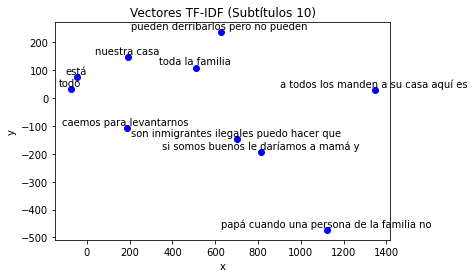

In [22]:
#Solo se gráfican algunas oraciones
plot_words(X_pca[20:30], list(vectors.keys())[20:30])
plt.title('Vectores TF-IDF (Subtítulos 10)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Con todos los subtítulos

10it [00:00, 5776.48it/s]


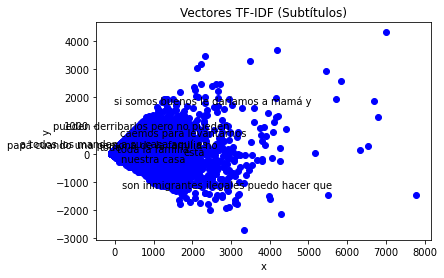

In [23]:
plot_words(X_pca, list(vectors.keys())[20:30])
plt.title('Vectores TF-IDF (Subtítulos)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Gráficamos los vectores de TF-IDF de cada vídeo 

In [24]:
#Cargamos el corpus limpio
videos = Data("../pkl/clean_videos.pkl")
videos.get_all_subtitles()
#Creamos el objeto tfidf
tfidf_obj = TFIDF(videos)
# Cargamos los valores tfidf previamente calculados
tfidf_obj.tfidf = "../pkl/tfidf.pkl" #Vectores por texto

100%|██████████| 9/9 [00:00<00:00, 18.20it/s]


In [25]:
def get_vectors_video():
    '''
    Regresa un diccionario con los subtítulos y su vector tfidf
    '''
    max = 0
    vectors = {}
    #Iteramos sobre los canales
    for id in tqdm(tfidf_obj.tfidf):
        vectors[id] = list(tfidf_obj.tfidf[id].values())
        max = len(vectors[id]) if len(vectors[id]) > max else max
    return vectors, max

In [26]:
vectors_video, max = get_vectors_video()
for id in tqdm(vectors_video):
        tfidf_obj.do_padding(vectors_video[id], max)
print("Longitud del vector más largo:", max)

100%|██████████| 3276/3276 [00:00<00:00, 7743.46it/s]

Longitud del vector más largo: 2235


In [27]:
val_pca = mds_model.fit_transform(list(vectors_video.values()))

Con 10 videos

10it [00:00, 3136.63it/s]


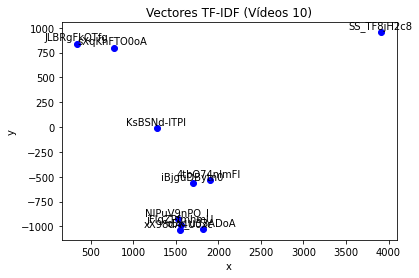

In [28]:
#Solo se gráfican algunos vídeos
plot_words(val_pca[50:60], list(tfidf_obj.tfidf.keys())[50:60])
plt.title('Vectores TF-IDF (Vídeos 10)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Con todos los videos

1it [00:00, 301.34it/s]


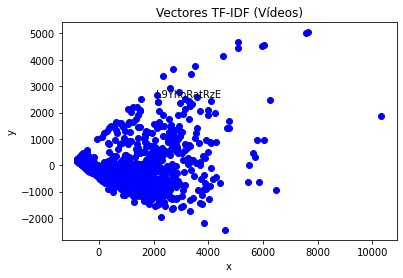

In [29]:
#Solo se gráfican vídeos
plot_words(val_pca, list(tfidf_obj.tfidf.keys())[:1])
plt.title('Vectores TF-IDF (Vídeos)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Podemos notar que a simple vista parece, y gracias a PCA, que no hay grupos definidos en el corpus, y que de hecho es muy similar utilizar los vectores por subtítulos que los vectores de vídeos, pero esto podría ser una conjetura erronea pues al reducir la dimensión de estamos perdiento datos, para comprobar si esto es cierto o no realizaremos el algortimo de k-means